In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load and preprocess data
data = pd.read_excel("C:/Users/TEMP.NDOCY.000/Desktop/spaza_shop_sales_data_7_shops.xlsx", parse_dates=['Date'], index_col='Date')



In [3]:
# Data Cleaning and Preprocessing
# 1. Handle Missing Values
data['Local_Event'] = data['Local_Event'].fillna('No Event')



In [4]:
# 2. Handle Outliers in 'Sales_Units'
# Define outlier threshold (e.g., 1.5 * IQR for simplicity)
Q1 = data['Sales_Units'].quantile(0.25)
Q3 = data['Sales_Units'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold_low = Q1 - 1.5 * IQR
outlier_threshold_high = Q3 + 1.5 * IQR



In [5]:
# Remove outliers
data = data[(data['Sales_Units'] >= outlier_threshold_low) & (data['Sales_Units'] <= outlier_threshold_high)]



In [6]:
# 3. Process Seasonality
data['Year'] = data.index.year
data['Month'] = data.index.month
data['DayOfWeek'] = data.index.dayofweek



In [7]:
# Aggregate sales data by date


data_daily = data.groupby(data.index).agg({'Sales_Units': 'sum'}).reset_index()

In [8]:
# Use 'Sales_Units' for forecasting
series = data_daily['Sales_Units'].values.reshape(-1, 1)



In [9]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(series)



In [10]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 15
X, y = create_sequences(scaled_series, SEQ_LENGTH)



In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to tensors
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)


In [11]:
# Split into train and test sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]



In [12]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)



In [16]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [17]:

# Initialize model, loss function, and optimizer
input_size = 1
hidden_size = 100
num_layers = 3
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [19]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')




# Track training and validation loss
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validate
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
        
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')



Epoch [5/50], Loss: 0.0223
Epoch [10/50], Loss: 0.0223
Epoch [15/50], Loss: 0.0223
Epoch [20/50], Loss: 0.0223
Epoch [25/50], Loss: 0.0223
Epoch [30/50], Loss: 0.0223
Epoch [35/50], Loss: 0.0223
Epoch [40/50], Loss: 0.0223
Epoch [45/50], Loss: 0.0223
Epoch [50/50], Loss: 0.0223
Epoch [5/50], Train Loss: 0.0223, Val Loss: 0.0217
Epoch [10/50], Train Loss: 0.0223, Val Loss: 0.0217
Epoch [15/50], Train Loss: 0.0223, Val Loss: 0.0217
Epoch [20/50], Train Loss: 0.0223, Val Loss: 0.0217
Epoch [25/50], Train Loss: 0.0223, Val Loss: 0.0217
Epoch [30/50], Train Loss: 0.0223, Val Loss: 0.0217
Epoch [35/50], Train Loss: 0.0223, Val Loss: 0.0217
Epoch [40/50], Train Loss: 0.0223, Val Loss: 0.0217
Epoch [45/50], Train Loss: 0.0223, Val Loss: 0.0217
Epoch [50/50], Train Loss: 0.0223, Val Loss: 0.0217


In [20]:
# Evaluate model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = scaler.inverse_transform(predictions.numpy())
    y_test_actual = scaler.inverse_transform(y_test_tensor.numpy())



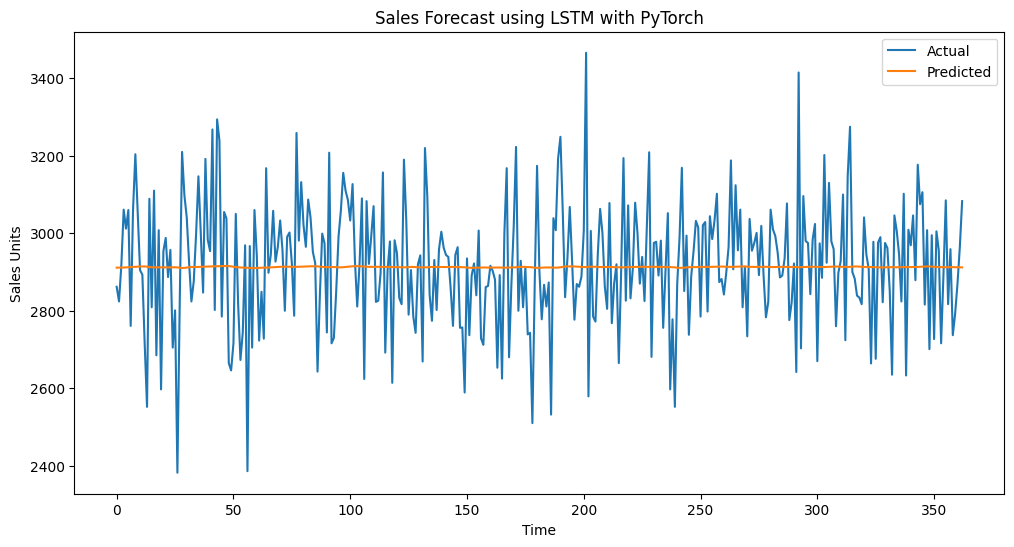

In [21]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_actual)), y_test_actual, label='Actual')
plt.plot(np.arange(len(predictions)), predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Sales Units')
plt.title('Sales Forecast using LSTM with PyTorch')
plt.legend()
plt.show()



In [22]:
# Forecast future values
#def forecast_future(model, initial_sequence, n_steps):
   # model.eval()
    #future = []
    #sequence = initial_sequence.tolist()
    #with torch.no_grad():
       # for _ in range(n_steps):
            #x = torch.FloatTensor(sequence[-SEQ_LENGTH:]).unsqueeze(0)
            #prediction = model(x)
            #future.append(prediction.item())
           # sequence.append(prediction.item())
    #return future




def forecast_future(model, initial_sequence, n_steps, seq_length):
    model.eval()
    future = []
    sequence = list(initial_sequence)
    
    with torch.no_grad():
        for _ in range(n_steps):
            x = torch.FloatTensor(sequence[-seq_length:]).unsqueeze(0).to(model.lstm.weight_ih_l0.device)
            prediction = model(x)
            future.append(prediction.item())
            sequence.append(prediction.item())
    
    return future



In [23]:
# Prepare initial sequence from the end of the dataset
initial_sequence = scaled_series[-SEQ_LENGTH:]



In [24]:
def forecast_future(model, initial_sequence, n_steps, seq_length):
    model.eval()
    future = []
    sequence = initial_sequence.tolist()  # Convert to list if not already
    with torch.no_grad():
        # Convert the initial sequence to a tensor
        x = torch.FloatTensor(sequence[-seq_length:]).unsqueeze(0).unsqueeze(-1)
        x = x.to(next(model.parameters()).device)  # Move tensor to the same device as the model
        
        for _ in range(n_steps):
            # Forward pass
            prediction = model(x)
            future.append(prediction.item())
            
            # Update the sequence with the new prediction
            sequence.append(prediction.item())
            
            # Prepare the next input sequence
            x = torch.FloatTensor(sequence[-seq_length:]).unsqueeze(0).unsqueeze(-1)
            x = x.to(next(model.parameters()).device)  # Move tensor to the same device as the model
            
    return future


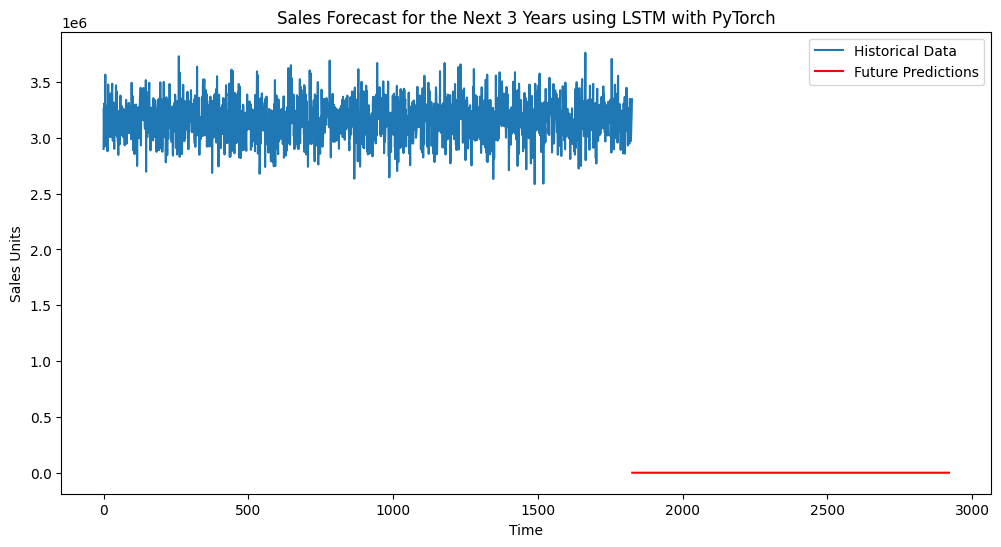

In [25]:
# Prepare initial sequence from the end of the dataset
initial_sequence = scaled_series[-SEQ_LENGTH:].flatten()  # Flatten to 1D array

# Forecast for the next 3 years (assuming daily data)
n_steps = 3 * 365
future_predictions = forecast_future(model, initial_sequence, n_steps, SEQ_LENGTH)

# Inverse transform the future predictions
future_predictions_actual = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Plot historical data and future predictions
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(series)), scaler.inverse_transform(series), label='Historical Data')
plt.plot(np.arange(len(series), len(series) + len(future_predictions_actual)), future_predictions_actual, label='Future Predictions', color='red')
plt.xlabel('Time')
plt.ylabel('Sales Units')
plt.title('Sales Forecast for the Next 3 Years using LSTM with PyTorch')
plt.legend()
plt.show()
